# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import gc

import urllib.request
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

sys.path.append('..')
from src import config, dataset, models

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

# Parameters

In [3]:
# prediction horizon
horizon = 28

# The dataset is quite large with 46 million records. We use only a fraction of it for training.
last_day = 1913
start_day = last_day - 3 * horizon

# Data

In [4]:
path = config.get_processed_filename('data_merged.parquet')
df_train = pd.read_parquet(path)

df_train = df_train[df_train.day_ind >= start_day]

sample = np.random.choice(df_train.id.unique(), 1000)
df_train = df_train[df_train.id.isin(sample)]

# sort by date for later
df_train = df_train.sort_values('date')

gc.collect()

print(f'Consolidated sales series dataset:{df_train.shape}')
print(df_train.dtypes)
df_train.head()

Consolidated sales series dataset:(110740, 20)
id                      object
item_id               category
dept_id               category
cat_id                category
store_id              category
state_id              category
day_ind                  int16
sold_qty               float64
date            datetime64[ns]
wday                      int8
month                     int8
year                     int16
event_name_1            object
event_type_1          category
event_name_2            object
event_type_2          category
snap_CA                   bool
snap_TX                   bool
snap_WI                   bool
sell_price             float64
Length: 20, dtype: object


,id,item_id,dept_id,cat_id,store_id,state_id,day_ind,sold_qty,date,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
43406084,HOBBIES_1_023_CA_1_validation,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_1,CA,1829,0.0,2016-01-31,2,1,2016,None,NaN,None,NaN,False,False,False,2.97
43478709,HOUSEHOLD_2_160_CA_4_validation,HOUSEHOLD_2_160,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,1829,0.0,2016-01-31,2,1,2016,None,NaN,None,NaN,False,False,False,3.93
43589918,FOODS_2_073_WI_2_validation,FOODS_2_073,FOODS_2,FOODS,WI_2,WI,1829,0.0,2016-01-31,2,1,2016,None,NaN,None,NaN,False,False,False,5.98
43478422,HOUSEHOLD_2_119_CA_4_validation,HOUSEHOLD_2_119,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,1829,0.0,2016-01-31,2,1,2016,None,NaN,None,NaN,False,False,False,5.84
43478345,HOUSEHOLD_2_108_CA_4_validation,HOUSEHOLD_2_108,HOUSEHOLD_2,HOUSEHOLD,CA_4,CA,1829,0.0,2016-01-31,2,1,2016,None,NaN,None,NaN,False,False,False,8.88


The base dataset is composed of a set of timeseries (identified by the column id) sampled on a daily basis and of length 365.
We have to predict two periods the following 28 days (day 1914 to 1941) on which the public score is calculated, and defined as the validation period (_validation suffix)
Later on, the ground truth on the valdiation period will be made available and we will have to predict sales for another window (day 1942 to 1969, _evaluation suffix).

# Feature engineering

## Convert to categories

In [5]:
df_train = dataset.categorical_to_ordinal(df_train)
df_train = df_train.sort_values('date')

gc.collect()

print(df_train.shape)
print(df_train.day_ind.min())
print(df_train.day_ind.max())

df_train.head()

(110740, 15)
1829
1941


,id,item_id,dept_id,cat_id,store_id,state_id,day_ind,sold_qty,date,wday,month,year,event_type_1,sell_price,snap
43406084,HOBBIES_1_023_CA_1_validation,1459,3,1,0,0,1829,0.0,2016-01-31,2,1,2016,4,2.97,0
43580993,HOUSEHOLD_1_063_WI_2_validation,2062,5,2,8,2,1829,0.0,2016-01-31,2,1,2016,4,9.97,0
43501774,HOUSEHOLD_2_407_TX_1_validation,2939,6,2,4,1,1829,0.0,2016-01-31,2,1,2016,4,4.94,0
43501662,HOUSEHOLD_2_391_TX_1_validation,2923,6,2,4,1,1829,1.0,2016-01-31,2,1,2016,4,12.94,0
43501221,HOUSEHOLD_2_328_TX_1_validation,2860,6,2,4,1,1829,0.0,2016-01-31,2,1,2016,4,7.47,0


## Time dependent features

In [7]:
categories = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wday', 'snap'] # if there is less than 1 year of data, year month and event_type_1 are useless

for c in categories:
    df_train = dataset.hierarchy_stats(df_train, c, ['sold_qty', 'sell_price'])
    
    df_grouped = df_train.groupby([c, 'date'])
    df_train = dataset.hierarchy_rolling_mean(df_train, c, ['sold_qty', 'sell_price'], window=7, shift=28, df_grouped=df_grouped)
    df_train = dataset.hierarchy_rolling_std(df_train, c, ['sold_qty', 'sell_price'], window=7, shift=28, df_grouped=df_grouped)
    df_train = dataset.hierarchy_rolling_mean(df_train, c, ['sold_qty', 'sell_price'], window=28, shift=28, df_grouped=df_grouped)
    df_train = dataset.hierarchy_rolling_std(df_train, c, ['sold_qty', 'sell_price'], window=28, shift=28, df_grouped=df_grouped)

# lag per id
df_grouped = df_train.groupby('id', as_index=False)
df_train = dataset.item_lag(df_train, ['sold_qty'], n_most=2, after=28, df_grouped=df_grouped)

# exclude rows with nan due to lagged features
df_train.dropna(subset=[c for c in df_train.columns if c != 'sold_qty'], inplace=True)

# remove columns with zero variance
col_std = df_train[df_train.select_dtypes([np.number]).columns].std()
cols_to_drop = col_std[col_std == 0].index
df_train.drop(cols_to_drop, axis=1, inplace=True)

print(f'dropped {len(cols_to_drop)} columns')

print(df_train.shape)
print(df_train.day_ind.min())
print(df_train.day_ind.max())

gc.collect()
df_train.head()

dropped 3 columns
(74374, 84)
1859
1941


,id,item_id,dept_id,cat_id,store_id,state_id,day_ind,sold_qty,date,wday,month,event_type_1,sell_price,snap,item_id_sold_qty_mean,item_id_sold_qty_std,item_id_sold_qty_max,item_id_sell_price_mean,item_id_sell_price_std,item_id_sell_price_max,item_id_sold_qty_7d_mean,item_id_sell_price_7d_mean,item_id_sold_qty_28d_mean,item_id_sell_price_28d_mean,dept_id_sold_qty_mean,dept_id_sold_qty_std,dept_id_sold_qty_max,dept_id_sell_price_mean,dept_id_sell_price_std,dept_id_sell_price_max,dept_id_sold_qty_7d_mean,dept_id_sell_price_7d_mean,dept_id_sold_qty_28d_mean,dept_id_sell_price_28d_mean,cat_id_sold_qty_mean,cat_id_sold_qty_std,cat_id_sold_qty_max,cat_id_sell_price_mean,cat_id_sell_price_std,cat_id_sell_price_max,cat_id_sold_qty_7d_mean,cat_id_sell_price_7d_mean,cat_id_sold_qty_28d_mean,cat_id_sell_price_28d_mean,store_id_sold_qty_mean,store_id_sold_qty_std,store_id_sold_qty_max,store_id_sell_price_mean,store_id_sell_price_std,store_id_sell_price_max,store_id_sold_qty_7d_mean,store_id_sell_price_7d_mean,store_id_sold_qty_28d_mean,store_id_sell_price_28d_mean,state_id_sold_qty_mean,state_id_sold_qty_std,state_id_sold_qty_max,state_id_sell_price_mean,state_id_sell_price_std,state_id_sell_price_max,state_id_sold_qty_7d_mean,state_id_sell_price_7d_mean,state_id_sold_qty_28d_mean,state_id_sell_price_28d_mean,wday_sold_qty_mean,wday_sold_qty_std,wday_sold_qty_max,wday_sell_price_mean,wday_sell_price_std,wday_sold_qty_7d_mean,wday_sell_price_7d_mean,wday_sold_qty_28d_mean,wday_sell_price_28d_mean,snap_sold_qty_mean,snap_sold_qty_std,snap_sold_qty_max,snap_sell_price_mean,snap_sell_price_std,snap_sold_qty_7d_mean,snap_sell_price_7d_mean,snap_sold_qty_28d_mean,snap_sell_price_28d_mean,sold_qty_lag_0,sold_qty_lag_1
44331997,HOUSEHOLD_2_108_CA_4_validation,2641,6,2,3,0,1859,0.0,2016-03-01,4,3,4,8.88,2,0.0000,0.0000,0.0,8.880,0.0000,8.88,2.8536,1.5952,1.8630,5.1337,0.4148,1.0262,14.0,5.6512,3.0578,20.97,67.8398,335.6275,66.6504,291.4999,0.9101,2.4383,67.0,5.6530,3.6021,20.97,257.6398,159.2129,250.3274,205.2930,0.9344,1.7071,15.0,4.7354,4.1979,22.98,29.0730,36.3861,25.2309,39.7578,1.4470,2.9557,52.0,4.7029,3.7198,29.96,1.3911e+02,279.3737,131.1544,263.3961,1.1092,2.8863,85.0,4.5406,3.5503,0.0,0.0,0.0000,1.7793e-05,1.2779,3.0918,77.0,4.5398,3.5504,0.0,0.0,0.0000,1.7793e-05,0.0,0.0
44300882,FOODS_3_633_CA_2_validation,1245,2,0,1,0,1859,0.0,2016-03-01,4,3,4,2.88,2,0.1311,0.4646,3.0,2.880,0.0000,2.88,0.7868,5.5139,1.8152,6.9521,2.3220,4.3996,85.0,2.9448,1.7948,11.46,250.7698,230.9398,173.3418,258.1121,1.8473,3.6494,85.0,3.3765,2.2081,13.98,308.2939,265.1053,265.8884,204.4500,1.0125,1.6807,15.0,4.5725,3.5306,20.53,73.0170,35.5704,71.0559,60.0734,1.4470,2.9628,52.0,4.7022,3.7179,29.96,1.0101e+02,201.8552,129.9588,269.1483,1.1113,2.9072,85.0,4.5399,3.5473,0.0,0.0,17.7756,1.7793e-05,1.2783,3.1021,77.0,4.5394,3.5487,0.0,0.0,17.7756,1.7793e-05,0.0,0.0
44311403,HOUSEHOLD_2_216_CA_3_validation,2748,6,2,2,0,1859,0.0,2016-03-01,4,3,4,5.94,2,0.0000,0.0000,0.0,6.811,0.3408,6.94,1.1339,5.0827,1.8039,4.3138,0.4142,1.0254,14.0,5.6509,3.0563,20.97,237.0910,220.5143,201.8927,249.2995,0.9119,2.4521,67.0,5.6530,3.6008,20.97,193.5178,112.5805,268.5112,198.3815,2.1794,4.0800,52.0,4.7562,3.8489,29.96,70.8929,36.1098,76.1156,56.8300,1.4464,2.9623,52.0,4.7022,3.7174,29.96,1.0101e+02,201.8552,116.4797,239.7531,1.1101,2.9052,85.0,4.5402,3.5455,0.0,0.0,15.4335,1.7793e-05,1.2775,3.1009,77.0,4.5396,3.5476,0.0,0.0,15.4335,1.7793e-05,0.0,0.0
44336288,FOODS_1_209_CA_4_validation,205,0,0,3,0,1859,0.0,2016-03-01,4,3,4,2.24,2,0.0968,0.3962,2.0,2.240,0.0000,2.24,10.2470,2.3459,5.3565,4.2280,1.2505,2.8216,32.0,3.3777,2.0561,9.98,221.2357,251.8151,208.0290,245.6927,1.8465,3.6487,85.0,3.3761,2.2078,13.98,273.6755,159.2129,270.5484,198.3815,0.9325,1.7030,15.0,4.7251,4.1897,22.98,91.4033,48.5667,84.6156,50.0447,1.4459,2.9619,52.0,4.7014,3.7171,29.96,3.2200e-05,0.0001,92.8493,191.0288,1.1084,2.9033,85.0,4.5389,3.5448,0.0,0.0,6.6144,1.7793e-05,1.2764,3.0998,77.0,4.5388,3.5472,0.0,0.0,6.6144,1.

# Prepare datasets for training and predictions

As a baseline model, samples are assumed independent and identically distributed. This is obviously wrong as they are actually part of ordered sequences.

In [17]:
# prepare training and test set
for c in categories:
    df_train[c] = df_train[c].astype('category')

# drop useless columns
useless_columns = ['id', 'day_ind', 'date', 'event_type_1']

# test set
test_ids = df_train.loc[df_train.sold_qty.isna(), 'id']
test_day_ind = df_train.loc[df_train.sold_qty.isna(), 'day_ind']
X_test = df_train.loc[df_train.sold_qty.isna()].drop(useless_columns + ['sold_qty'], axis=1)
    
# train and valid sets
y_train = df_train.loc[~df_train.sold_qty.isna(), 'sold_qty']
X_train = df_train.loc[~df_train.sold_qty.isna()].drop(useless_columns + ['sold_qty'], axis=1)

# weighting to give more importance to recent observations
sample_w = df_train.loc[~df_train.sold_qty.isna(), :].groupby('id')['day_ind'].transform(lambda x: dataset.exp_decay(x.size, w_min=.2))

#del df_train
gc.collect()

1686

In [19]:
print(X_train.shape)
X_train.head()

(46934, 79)


,item_id,dept_id,cat_id,store_id,state_id,wday,month,sell_price,snap,item_id_sold_qty_mean,item_id_sold_qty_std,item_id_sold_qty_max,item_id_sell_price_mean,item_id_sell_price_std,item_id_sell_price_max,item_id_sold_qty_7d_mean,item_id_sell_price_7d_mean,item_id_sold_qty_28d_mean,item_id_sell_price_28d_mean,dept_id_sold_qty_mean,dept_id_sold_qty_std,dept_id_sold_qty_max,dept_id_sell_price_mean,dept_id_sell_price_std,dept_id_sell_price_max,dept_id_sold_qty_7d_mean,dept_id_sell_price_7d_mean,dept_id_sold_qty_28d_mean,dept_id_sell_price_28d_mean,cat_id_sold_qty_mean,cat_id_sold_qty_std,cat_id_sold_qty_max,cat_id_sell_price_mean,cat_id_sell_price_std,cat_id_sell_price_max,cat_id_sold_qty_7d_mean,cat_id_sell_price_7d_mean,cat_id_sold_qty_28d_mean,cat_id_sell_price_28d_mean,store_id_sold_qty_mean,store_id_sold_qty_std,store_id_sold_qty_max,store_id_sell_price_mean,store_id_sell_price_std,store_id_sell_price_max,store_id_sold_qty_7d_mean,store_id_sell_price_7d_mean,store_id_sold_qty_28d_mean,store_id_sell_price_28d_mean,state_id_sold_qty_mean,state_id_sold_qty_std,state_id_sold_qty_max,state_id_sell_price_mean,state_id_sell_price_std,state_id_sell_price_max,state_id_sold_qty_7d_mean,state_id_sell_price_7d_mean,state_id_sold_qty_28d_mean,state_id_sell_price_28d_mean,wday_sold_qty_mean,wday_sold_qty_std,wday_sold_qty_max,wday_sell_price_mean,wday_sell_price_std,wday_sold_qty_7d_mean,wday_sell_price_7d_mean,wday_sold_qty_28d_mean,wday_sell_price_28d_mean,snap_sold_qty_mean,snap_sold_qty_std,snap_sold_qty_max,snap_sell_price_mean,snap_sell_price_std,snap_sold_qty_7d_mean,snap_sell_price_7d_mean,snap_sold_qty_28d_mean,snap_sell_price_28d_mean,sold_qty_lag_0,sold_qty_lag_1
44331997,2641,6,2,3,0,4,3,8.88,2,0.0000,0.0000,0.0,8.880,0.0000,8.88,2.8536,1.5952,1.8630,5.1337,0.4148,1.0262,14.0,5.6512,3.0578,20.97,67.8398,335.6275,66.6504,291.4999,0.9101,2.4383,67.0,5.6530,3.6021,20.97,257.6398,159.2129,250.3274,205.2930,0.9344,1.7071,15.0,4.7354,4.1979,22.98,29.0730,36.3861,25.2309,39.7578,1.4470,2.9557,52.0,4.7029,3.7198,29.96,1.3911e+02,279.3737,131.1544,263.3961,1.1092,2.8863,85.0,4.5406,3.5503,0.0,0.0,0.0000,1.7793e-05,1.2779,3.0918,77.0,4.5398,3.5504,0.0,0.0,0.0000,1.7793e-05,0.0,0.0
44300882,1245,2,0,1,0,4,3,2.88,2,0.1311,0.4646,3.0,2.880,0.0000,2.88,0.7868,5.5139,1.8152,6.9521,2.3220,4.3996,85.0,2.9448,1.7948,11.46,250.7698,230.9398,173.3418,258.1121,1.8473,3.6494,85.0,3.3765,2.2081,13.98,308.2939,265.1053,265.8884,204.4500,1.0125,1.6807,15.0,4.5725,3.5306,20.53,73.0170,35.5704,71.0559,60.0734,1.4470,2.9628,52.0,4.7022,3.7179,29.96,1.0101e+02,201.8552,129.9588,269.1483,1.1113,2.9072,85.0,4.5399,3.5473,0.0,0.0,17.7756,1.7793e-05,1.2783,3.1021,77.0,4.5394,3.5487,0.0,0.0,17.7756,1.7793e-05,0.0,0.0
44311403,2748,6,2,2,0,4,3,5.94,2,0.0000,0.0000,0.0,6.811,0.3408,6.94,1.1339,5.0827,1.8039,4.3138,0.4142,1.0254,14.0,5.6509,3.0563,20.97,237.0910,220.5143,201.8927,249.2995,0.9119,2.4521,67.0,5.6530,3.6008,20.97,193.5178,112.5805,268.5112,198.3815,2.1794,4.0800,52.0,4.7562,3.8489,29.96,70.8929,36.1098,76.1156,56.8300,1.4464,2.9623,52.0,4.7022,3.7174,29.96,1.0101e+02,201.8552,116.4797,239.7531,1.1101,2.9052,85.0,4.5402,3.5455,0.0,0.0,15.4335,1.7793e-05,1.2775,3.1009,77.0,4.5396,3.5476,0.0,0.0,15.4335,1.7793e-05,0.0,0.0
44336288,205,0,0,3,0,4,3,2.24,2,0.0968,0.3962,2.0,2.240,0.0000,2.24,10.2470,2.3459,5.3565,4.2280,1.2505,2.8216,32.0,3.3777,2.0561,9.98,221.2357,251.8151,208.0290,245.6927,1.8465,3.6487,85.0,3.3761,2.2078,13.98,273.6755,159.2129,270.5484,198.3815,0.9325,1.7030,15.0,4.7251,4.1897,22.98,91.4033,48.5667,84.6156,50.0447,1.4459,2.9619,52.0,4.7014,3.7171,29.96,3.2200e-05,0.0001,92.8493,191.0288,1.1084,2.9033,85.0,4.5389,3.5448,0.0,0.0,6.6144,1.7793e-05,1.2764,3.0998,77.0,4.5388,3.5472,0.0,0.0,6.6144,1.7793e-05,0.0,2.0
44359304,444,1,0,4,1,4,3,2.18,2,0.0000,0.0000,0.0,2.180,0.0000,2.18,1.4142,3.9899,5.2730,4.4258,1.3150,2.1136,23.0,4.1515,2.6961,13.98,252.4737,245.3695,213.1601,212.5850,1.8478,3.6508,85.0,3.3759,2.2076,13.98,249.8304,145.3408,2

In [20]:
print(X_test.shape)
X_test.head()

(27440, 79)


,item_id,dept_id,cat_id,store_id,state_id,wday,month,sell_price,snap,item_id_sold_qty_mean,item_id_sold_qty_std,item_id_sold_qty_max,item_id_sell_price_mean,item_id_sell_price_std,item_id_sell_price_max,item_id_sold_qty_7d_mean,item_id_sell_price_7d_mean,item_id_sold_qty_28d_mean,item_id_sell_price_28d_mean,dept_id_sold_qty_mean,dept_id_sold_qty_std,dept_id_sold_qty_max,dept_id_sell_price_mean,dept_id_sell_price_std,dept_id_sell_price_max,dept_id_sold_qty_7d_mean,dept_id_sell_price_7d_mean,dept_id_sold_qty_28d_mean,dept_id_sell_price_28d_mean,cat_id_sold_qty_mean,cat_id_sold_qty_std,cat_id_sold_qty_max,cat_id_sell_price_mean,cat_id_sell_price_std,cat_id_sell_price_max,cat_id_sold_qty_7d_mean,cat_id_sell_price_7d_mean,cat_id_sold_qty_28d_mean,cat_id_sell_price_28d_mean,store_id_sold_qty_mean,store_id_sold_qty_std,store_id_sold_qty_max,store_id_sell_price_mean,store_id_sell_price_std,store_id_sell_price_max,store_id_sold_qty_7d_mean,store_id_sell_price_7d_mean,store_id_sold_qty_28d_mean,store_id_sell_price_28d_mean,state_id_sold_qty_mean,state_id_sold_qty_std,state_id_sold_qty_max,state_id_sell_price_mean,state_id_sell_price_std,state_id_sell_price_max,state_id_sold_qty_7d_mean,state_id_sell_price_7d_mean,state_id_sold_qty_28d_mean,state_id_sell_price_28d_mean,wday_sold_qty_mean,wday_sold_qty_std,wday_sold_qty_max,wday_sell_price_mean,wday_sell_price_std,wday_sold_qty_7d_mean,wday_sell_price_7d_mean,wday_sold_qty_28d_mean,wday_sell_price_28d_mean,snap_sold_qty_mean,snap_sold_qty_std,snap_sold_qty_max,snap_sell_price_mean,snap_sell_price_std,snap_sold_qty_7d_mean,snap_sell_price_7d_mean,snap_sold_qty_28d_mean,snap_sell_price_28d_mean,sold_qty_lag_0,sold_qty_lag_1
46159318,1473,3,1,9,2,3,4,12.97,0,0.4706,0.6471,2.0,12.970,0.0000,12.97,8.7532,7.5052,4.9914,7.1885,0.5784,1.4268,52.0,6.2553,5.3514,29.96,77.4102,331.4121,138.5358,279.4262,0.5068,1.3076,52.0,5.5053,5.0296,29.96,433.4366,295.8170,398.4197,298.2048,0.7654,1.7244,31.0,4.8356,3.7016,17.97,12.2727,28.3931,22.8861,23.9373,1.2520,3.5483,128.0,4.5753,3.5940,29.96,112.1122,236.7050,104.0989,220.4102,1.2139,2.7405,77.0,4.5384,3.5506,1.1321e-05,0.0,0.0001,7.7326e-06,1.2583,2.8975,85.0,4.5379,3.5498,1.1321e-05,0.0,0.0001,7.7326e-06,0.0,0.0
46029160,1173,2,0,2,0,3,4,2.98,0,4.2588,4.0005,21.0,2.980,0.0000,2.98,8.6162,7.4275,4.9670,7.2436,2.3444,4.4228,128.0,2.9470,1.7887,11.98,90.4468,335.9310,138.5358,279.4262,1.8641,3.6883,128.0,3.3752,2.2041,13.98,373.6312,158.5394,398.4197,298.2048,2.1319,3.8157,52.0,4.7526,3.8535,29.96,17.5350,20.3241,23.2258,24.5713,1.4314,2.8312,52.0,4.7036,3.7210,29.96,146.3850,305.7007,113.4960,238.5459,1.2139,2.7405,77.0,4.5382,3.5505,1.1321e-05,0.0,0.0001,7.7326e-06,1.2583,2.8975,85.0,4.5379,3.5498,1.1321e-05,0.0,0.0001,7.7326e-06,0.0,5.0
46128483,117,0,0,7,2,3,4,1.96,0,0.0529,0.3127,3.0,1.960,0.0000,1.96,8.5328,7.6692,4.9505,7.3145,1.3385,2.9997,43.0,3.3822,2.0591,9.98,224.5521,301.9278,176.2103,274.9438,1.8641,3.6883,128.0,3.3752,2.2041,13.98,341.0771,144.7260,403.4116,294.0915,1.2326,2.5476,36.0,4.3136,3.0900,19.98,19.3366,20.4667,22.9461,24.6089,1.2520,3.5483,128.0,4.5752,3.5939,29.96,160.3568,334.8783,120.6743,252.3248,1.2139,2.7405,77.0,4.5380,3.5504,1.1321e-05,0.0,0.0001,7.7326e-06,1.2583,2.8975,85.0,4.5378,3.5498,1.1321e-05,0.0,0.0001,7.7326e-06,0.0,0.0
46172394,292,1,0,9,2,3,4,5.92,0,1.2000,1.3697,5.0,6.187,0.2813,6.48,8.7123,7.5788,5.2849,7.3330,1.2847,2.1166,23.0,4.1423,2.6947,13.98,273.6143,276.0477,204.2730,270.1299,1.8641,3.6883,128.0,3.3753,2.2041,13.98,341.0771,144.7260,406.7566,289.5182,0.7654,1.7244,31.0,4.8358,3.7014,17.97,28.5757,23.8138,24.3768,25.0809,1.2520,3.5483,128.0,4.5753,3.5939,29.96,152.8697,315.7945,119.6758,249.9175,1.2139,2.7405,77.0,4.5381,3.5503,1.1321e-05,0.0,0.0001,7.7326e-06,1.2583,2.8975,85.0,4.5379,3.5497,1.1321e-05,0.0,0.0001,7.7326e-06,2.0,4.0
45990226,1709,3,1,1,0,3,4,10.98,0,0.4471,0.6638,2.0,10.980,0.0000,10.98,8.8291,7.7072,5.2849,7.3748,0.5784,1.4268,52.0,6.2557,5.3513,29.96,283.6651,223.5728,226.3280,264.966

# Train

In [23]:
print('Train model...')
model = models.LGBModel()
model.optimize(X_train, y_train, sample_weights=sample_w, n_trials=10, metric='rmse')

print('\nBest params:')
for k, v in model.best_params.items():
    print(f'   {k}: {v}')

Train model...
   metric: mape
   trial 5 - best running loss: 0.556
   trial 10 - best running loss: 0.385
   best loss: 0.385

Best params:
   objective: mape
   metric: mape
   learning_rate: 0.0020619750380873486
   lambda_l1: 6.536986956480616e-06
   lambda_l2: 6.760876857811031e-06
   num_leaves: 48
   feature_fraction: 0.7174191614421447
   bagging_fraction: 0.5645948116253854
   bagging_freq: 1
   min_child_samples: 66
   min_data_in_leaf: 201


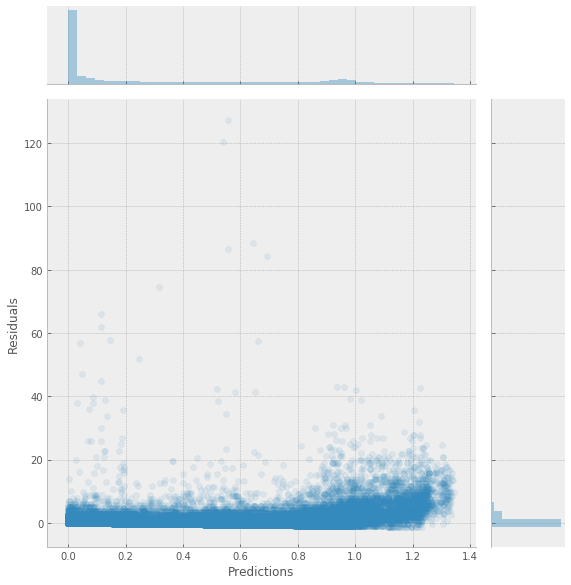

In [24]:
# plot redisuals
y_train_hat = model.predict(X_train)
residuals = y_train - y_train_hat

sns.jointplot(y_train_hat, residuals, alpha=.1, height=8).set_axis_labels('Predictions', 'Residuals')

# Predict

In [ ]:
# inference on test set
y_hat_test = model.predict(X_test)
df_predictions = pd.DataFrame({'id': test_ids, 'd': test_day_ind, 'sold_qty': y_hat_test})

# transform to the required format for submissions
df_predictions = df_predictions.pivot(index='id', columns='d', values='sold_qty')
df_predictions.columns = [f'F{i + 1}' for i, c in enumerate(df_predictions.columns)]
df_predictions.reset_index(inplace=True)

# duplicate and append predictions for evaluation period, as validation period is not known yet
df_predictions_eval = df_predictions.copy()
df_predictions_eval.id = df_predictions_eval.id.str.replace('validation', 'evaluation')

df_predictions = pd.concat([df_predictions, df_predictions_eval], axis=0).reset_index(drop=True)
del df_predictions_eval

# save to directory
#path = config.get_submission_filename('submit_baseline.csv')
df_predictions.to_csv(path, index=False)

df_predictions.head()